### Convolutional Neural Network로 숫자분류기 구현하기

In [18]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

In [3]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg = mnist.train.images
trainlabel = mnist.train.labels
testimg = mnist.test.images
testlabel = mnist.test.labels
print("MNIST Ready.")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST Ready.


##### 1. Define Model

In [4]:
n_input = 784
n_channel = 64 # convolution filter의 갯수
n_classes = 10

# input and output
x = tf.placeholder(dtype='float', shape=[None, n_input])
y = tf.placeholder(dtype='float', shape=[None, n_classes])

# Network Parameters
# CNN에서는 Convolutional kernel이 있어야함.
stddev = 0.1
weights = {
    # convolution layer 2개 , dense layer 1개
    'c1' : tf.Variable(initial_value=tf.random_normal(shape=[3,3,1,n_channel], stddev=stddev)),
    'c2' : tf.Variable(initial_value=tf.random_normal(shape=[3,3,n_channel,128], stddev=stddev)),
    'd1' : tf.Variable(initial_value=tf.random_normal(shape=[7*7*128, n_classes], stddev=stddev))
}
biases = {
    # convolution layer 2개 , dense layer 1개
    'c1' : tf.Variable(initial_value=tf.random_normal(shape=[n_channel],stddev=stddev)),
    'c2' : tf.Variable(initial_value=tf.random_normal(shape=[128], stddev=stddev)),
    'd1' : tf.Variable(initial_value=tf.random_normal(shape=[n_classes], stddev=stddev))
}
print("Network Ready!!")

Network Ready!!


##### 2. Define Graph 

In [6]:
def CNN(_x, _w, _b):
    # Reshape
    _x_r = tf.reshape(_x, shape=[-1,28,28,1])
    # Convolution
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1,1,1,1], padding='SAME')
    # Add Bias
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # ReLU
    _conv3 = tf.nn.relu(_conv2)
    # Max Pool
    # Non-overlapping
    _pool = tf.nn.max_pool(_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # 2nd Convolutional Layer
    _temp = tf.nn.conv2d(_pool, _w['c2'], strides=[1,1,1,1], padding='SAME')
    _temp = tf.nn.bias_add(_temp, _b['c2'])
    _temp = tf.nn.relu(_temp)
    _temp = tf.nn.max_pool(_temp, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Vectorize (한 줄로 편다.)
    _dense = tf.reshape(_temp, shape=[-1, _w['d1'].get_shape().as_list()[0]])
    # Dense
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    # 결과물을 dict 형태로 출력하게 되면
    # debugging에 용이하다!! (중요)
    _out = {
        'x_r':_x_r, 'conv1':_conv1, 'conv2' : _conv2, 'conv3': _conv3,
        'pool': _pool, 'dense': _dense, 'logit':_logit
    }
    return _out

# Prediction
cnnout = CNN(x,weights, biases)

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=cnnout['logit']))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct = tf.equal(tf.argmax(cnnout['logit'], 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct,'float'))

# Initialize
init = tf.global_variables_initializer()
print("Function Ready!!")

Function Ready!!


##### 3. Saver

In [19]:
savedir = "nets/cnn_mnist_simple/"
saver = tf.train.Saver(max_to_keep=3) # 최근 3개까지 저장하겠다.
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print("Saver Ready!!")

Saver Ready!!


##### 4. Run

In [10]:
training_epochs = 20
batch_size = 100
display_step = 4

# Launch the Graph
sess = tf.Session()
sess.run(init)

# Optimizer
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)
    # Iteration
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size=batch_size)
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optimizer, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # Display
    if (epoch + 1) % display_step == 0:
        print("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accuracy, feed_dict=feeds)
        print("Train Accuracy: %.3f" % (train_acc))
        feeds = {x: mnist.test.images[:100, :], y: mnist.test.labels[:100, :]}
        test_acc = sess.run(accuracy, feed_dict=feeds)
        print("Test Accuracy: %.3f" % (test_acc))
    # Save
    if(epoch + 1) % save_step == 0:
        savename = savedir + "net-" + str(epoch + 1) + ".ckpt"
        saver.save(sess, savename)
        print("[%s]Saved" % (savename))
print("Optimization Finished!!!")

Epoch: 004/020 cost: 0.024586656
Train Accuracy: 1.000
Test Accuracy: 1.000
[nets/cnn_mnist_simple/net-4.ckpt]Saved
Epoch: 008/020 cost: 0.008431986
Train Accuracy: 0.990
Test Accuracy: 0.990
[nets/cnn_mnist_simple/net-8.ckpt]Saved
Epoch: 012/020 cost: 0.003221259
Train Accuracy: 1.000
Test Accuracy: 0.980
[nets/cnn_mnist_simple/net-12.ckpt]Saved
Epoch: 016/020 cost: 0.001810243
Train Accuracy: 1.000
Test Accuracy: 0.990
[nets/cnn_mnist_simple/net-16.ckpt]Saved
Epoch: 020/020 cost: 0.001027976
Train Accuracy: 1.000
Test Accuracy: 0.990
[nets/cnn_mnist_simple/net-20.ckpt]Saved
Optimization Finished!!!


### Restore (불러오기)

In [20]:
do_train = 0
if do_train == 0:
    sess = tf.Session()
    epoch = 20
    savename = savedir + "net-" + str(epoch) + ".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print("Do Nothing")

INFO:tensorflow:Restoring parameters from nets/cnn_mnist_simple/net-20.ckpt
NETWORK RESTORED


### Let's see how CNN works

In [21]:
feed_dict = {x : trainimg[0:1,:]}
input_r = sess.run(cnnout['x_r'], feed_dict=feed_dict)
conv1 = sess.run(cnnout['conv1'], feed_dict=feed_dict)
conv2 = sess.run(cnnout['conv2'], feed_dict=feed_dict)
conv3 = sess.run(cnnout['conv3'], feed_dict=feed_dict)
pool = sess.run(cnnout['pool'], feed_dict=feed_dict)
dense = sess.run(cnnout['dense'], feed_dict=feed_dict)
out = sess.run(cnnout['logit'], feed_dict=feed_dict)

### INPUT

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


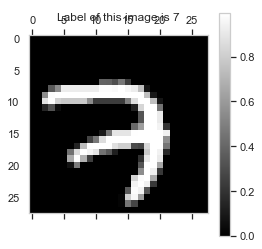

In [31]:
print("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0,:])
print("Label is %d" % (label))

# Plot
plt.matshow(input_r[0,:,:,0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label))
plt.colorbar()
plt.grid(False)
plt.show()

### Conv1 (Convolution)

Size of 'conv1' is (1, 28, 28, 64)


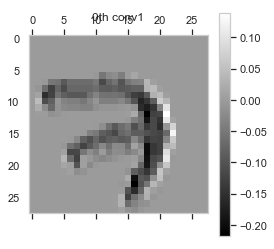

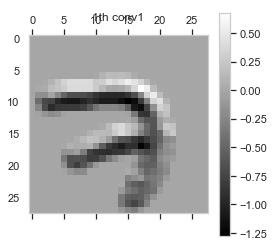

In [34]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(2):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Conv2 (Conv1 + Bias)
- 모양은 똑같은데, colorbar의 range를 바꿔준다.
- 이는 ReLU에 영향을 미친다.
- bias가 너무 작으면(예를 들어 -100), 대부분의 값이 ReLU를 통과하게 되면 0으로 바뀐다.
- **학습이 갑자기 안된다면, bias때문에 ReLU가 0이 되었는지 확인하자.**

Size of 'conv2' is (1, 28, 28, 64)


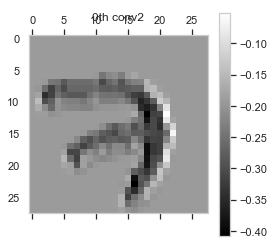

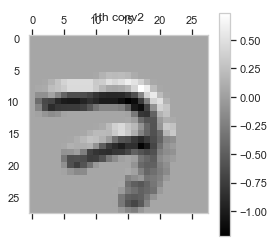

In [36]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(2):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Conv3(Conv2 --> ReLU)

Size of 'conv3' is (1, 28, 28, 64)


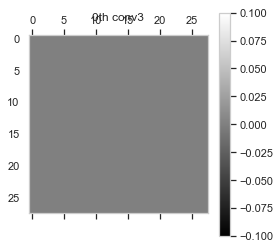

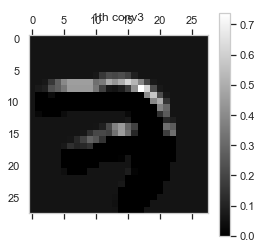

In [43]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(2):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Pool(Max_pool)

Size of 'pool' is (1, 14, 14, 64)


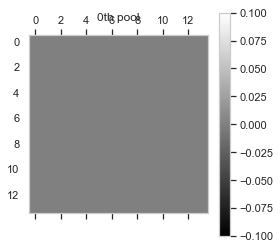

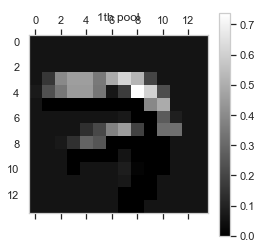

In [45]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(2):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Dense

Size of 'dense' is (1, 6272)
Size of 'out' is (1, 10)


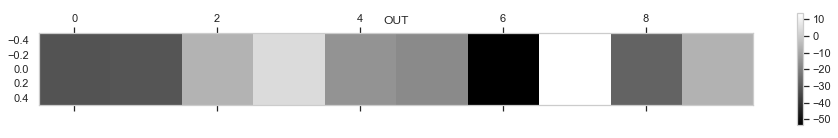

In [46]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))

plt.matshow(out, cmap=plt.get_cmap('gray'))
plt.title("OUT")
plt.grid(False)
plt.colorbar()
plt.show()

제일 큰 숫자는 7번째!

### Check Filters

Size of 'wc1' is (3, 3, 1, 64)


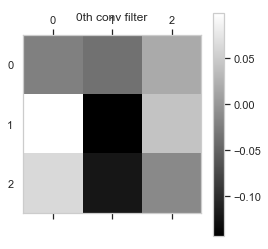

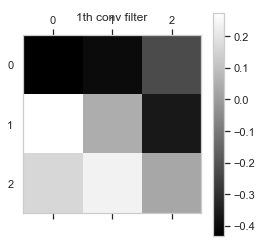

In [49]:
# Let's see weight! 
wc1 = sess.run(weights['c1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(2):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.grid(False)
    plt.show()